### Setting Up

In [ ]:
!nvidia-smi

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q torch transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Manuscript-Matcher

# Data Labelling

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Manuscript-Matcher/data.csv')

In [ ]:
asjc_df = pd.read_csv('/content/drive/MyDrive/Manuscript-Matcher/asjc_codes.csv')
asjc_df = asjc_df[['Code', 'ASJC category']]

In [ ]:
code2cat = dict(zip(asjc_df['Code'], asjc_df['ASJC category']))
cat2code = dict(zip(asjc_df['ASJC category'], asjc_df['Code']))

In [ ]:
def count_values(lst):
    counts = {}
    for sublist in lst:
        for item in sublist:
            if item in counts:
                counts[item] += 1
            else:
                counts[item] = 1
    return counts

In [ ]:
df.asjc_codes = df.asjc_codes.map(lambda x: [int(i) for i in eval(x)])

In [ ]:
code_counts = count_values(df.asjc_codes.to_list())
cat_counts = {code2cat[key]: value for key, value in code_counts.items()}

In [ ]:
threshold = int(len(df) * 0.01)
rare_cats = [key for key, value in cat_counts.items() if value < threshold]
len(rare_cats), rare_cats[:5]

(222,
 ['General Psychology',
  'General Veterinary',
  'Pediatrics, Perinatology and Child Health',
  'Neurology (clinical)',
  'Cell Biology'])

In [ ]:
revised_cats = [key for key, value in cat_counts.items() if value >= threshold]
len(revised_cats), revised_cats[:5]

In [ ]:
revised_cat_list = []
indices_to_drop = []

for idx, code_list in enumerate(df.asjc_codes.to_list()):
  categories = []

  for code in code_list:
    if code2cat[code] not in rare_cats:
      categories.append(code)

  if len(categories) == 0:
    indices_to_drop.append(idx)
  else:
    revised_cat_list.append(categories)

In [ ]:
len(revised_cat_list)

31416

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(31416, 4)

In [ ]:
df['revised_categories'] = revised_cat_list

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31416 entries, 0 to 31415
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   journal             31416 non-null  object
 1   title               31416 non-null  object
 2   abstract            31416 non-null  object
 3   asjc_codes          31416 non-null  object
 4   revised_categories  31416 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


In [ ]:
df.describe()

In [ ]:
revised_categories_count = count_values(df.revised_categories)

In [ ]:
categories_encoding = {key: idx for idx, (key, value) in enumerate(revised_categories_count.items())}

In [ ]:
categorical_list = []
revised_categories_list = df.revised_categories.to_list()

for revised_categories in revised_categories_list:
  temp = [0] * len(categories_encoding)
  for genre in revised_categories:
    index = categories_encoding[genre]
    temp[index] = 1
  categorical_list.append(temp)

In [ ]:
df['text'] = df.title.astype(str) + ". \n" + df.abstract.astype(str)

In [ ]:
df['label'] = categorical_list

In [ ]:
df.head()

### Save data

In [ ]:
df.to_csv('/content/drive/MyDrive/Manuscript-Matcher/labelled_data.csv', index=False)

# Dataloaders and Modeling

In [ ]:
labels = [code2cat[cat] for cat in list(categories_encoding.keys())]

In [ ]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
labels

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True, vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('text'), get_y=ColReader('label'), splitter=RandomSplitter(valid_pct=0.1, seed=7))

In [ ]:
dls = dblock.dataloaders(df, bs=32)

In [ ]:
torch.save(dls, "dataloaders/dls-manuscript-matcher.pkl")

In [ ]:
dls.vocab

['Cancer Research', 'Oncology', 'General Medicine', 'Public Health, Environmental and Occupational Health', 'Neurology', 'General Earth and Planetary Sciences', 'Infectious Diseases', 'Microbiology (medical)', 'Immunology', 'Microbiology', 'Biomedical Engineering', 'Biotechnology', 'Atomic and Molecular Physics, and Optics', 'General Physics and Astronomy', 'Renewable Energy, Sustainability and the Environment', 'General Biochemistry, Genetics and Molecular Biology', 'General Neuroscience', 'Radiology, Nuclear Medicine and Imaging', 'Social Psychology', 'Endocrinology, Diabetes and Metabolism', 'Pharmacology (medical)', 'Genetics', 'Molecular Medicine', 'Plant Science', 'Ecology', 'Ecology, Evolution, Behavior and Systematics', 'Molecular Biology', 'Biochemistry', 'Physical and Theoretical Chemistry', 'General Environmental Science', 'General Chemistry', 'Management, Monitoring, Policy and Law', 'Food Science', 'Computer Science Applications', 'Surgery', 'Pharmaceutical Science', 'Nutr

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,Simulation-enhanced lean design process. \n<!--[if gte mso 9]><xml> <o:OfficeDocumentSettings> <o:PixelsPerInch>72</o:PixelsPerInch> </o:OfficeDocumentSettings> </xml><![endif]--><!--[if gte mso 9]><xml> <w:WordDocument> <w:View>Normal</w:View> <w:Zoom>0</w:Zoom> <w:TrackMoves/> <w:TrackFormatting/> <w:PunctuationKerning/> <w:ValidateAgainstSchemas/> <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid> <w:IgnoreMixedContent>false</w:IgnoreMixedContent> <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderTe,[Strategy and Management]
1,"Ultradian rhythms in shell composition of photosymbiotic and non-photosymbiotic mollusks. \n<p>The chemical composition of mollusk shells is a useful tool in (paleo)climatology since it captures inter- and intra-annual variability in environmental conditions. Trace element and stable isotope analysis with improved sampling resolution now allows in situ determination of the composition of mollusk shell volumes precipitated at daily to sub-daily time intervals. Here, we discuss hourly resolved Mg <span class=","[Ecology, Evolution, Behavior and Systematics]"
2,"Finding a Novel Chalcone–Cinnamic Acid Chimeric Compound with Antiproliferative Activity against MCF-7 Cell Line Using a Free-Wilson Type Approach. \nIn this work, we carried out the design and synthesis of new chimeric compounds from the natural cytotoxic chalcone 2′,4′-dihydroxychalcone (2′,4′-DHC, <b>A</b>) in combination with cinnamic acids. For this purpose, a descriptive and predictive quantitative structure–activity relationship (QSAR) model was developed to study the chimeric compounds’ anti-cancer","[Molecular Medicine, Physical and Theoretical Chemistry, Pharmaceutical Science, Organic Chemistry, Chemistry (miscellaneous), Analytical Chemistry, Drug Discovery]"
3,"Ригидность сердечного ритма у больных с инфарктом миокарда. \nНеобходимость наблюдения за ритмом сердца у больных c ИМ общепризнана, при этом исключительно важное значение имеет своевременное предупреждение тяжелых осложнений и внезапной смерти. Анализ ВСР признан наиболее информативным методом неинвазивной оценки состояния автономной нервной системы в клинической практике. Основанный на изучении изменчивости продолжительности R-R интервалов за определенные промеж",[Education]


# Model Training

In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

## Stage 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0010000000474974513, valley=0.0002290867705596611)

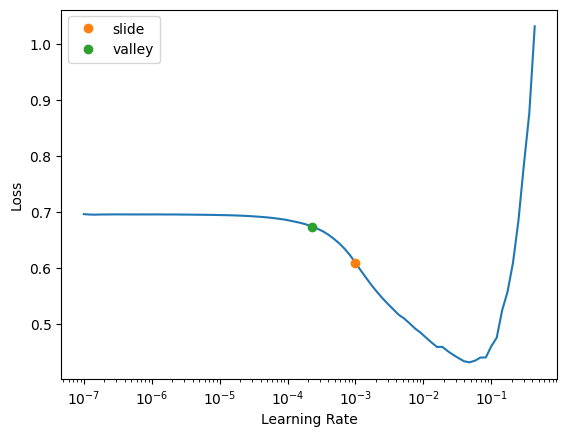

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(2, 6.15e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.080172,0.078093,0.959549,05:26
1,0.072363,0.070163,0.964904,05:26


In [ ]:
learner.save("manuscript-matcher-stage-0")

Path('models/manuscript-matcher-stage-0.pth')

In [ ]:
learner.export("models/manuscript-matcher-stage-0.pkl")

## Stage 1

In [ ]:
# learner.load("manuscript-matcher-stage-0")

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.0012022644514217973, valley=8.31763736641733e-06)

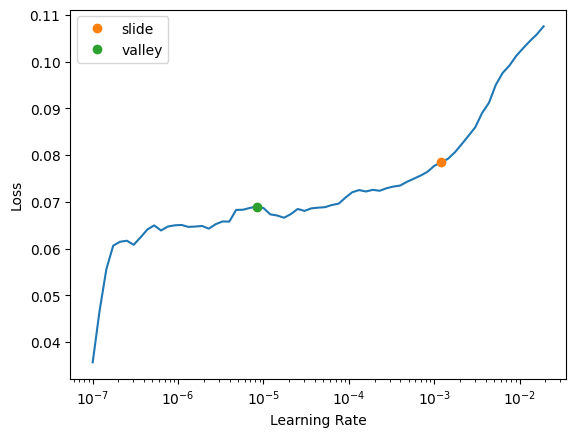

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(3, slice(8.1e-3, 8.5e-6))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.081550,0.075722,0.965187,06:27
1,0.065886,0.067280,0.967319,06:29
2,0.048867,0.064351,0.970109,06:27


In [ ]:
learner.save("manuscript-matcher-stage-1")

Path('models/manuscript-matcher-stage-1.pth')

In [ ]:
learner.export("models/manuscript-matcher-stage-1.pkl")

## Stage 2

In [ ]:
# learner.load("manuscript-matcher-stage-1")

SuggestedLRs(slide=0.0005754399462603033, valley=3.0199516913853586e-05)

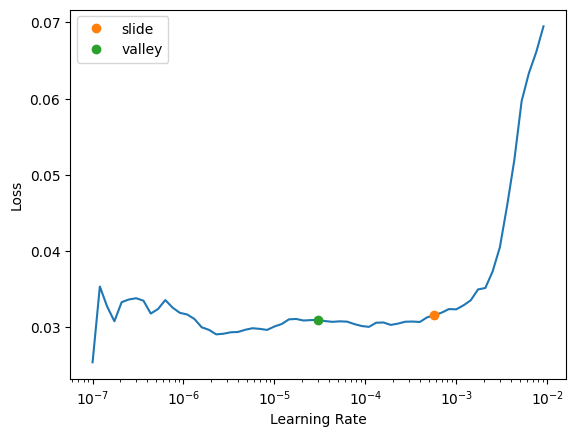

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5, slice(1e-4, 6.9e-6))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.041487,0.065719,0.970272,06:18
1,0.039102,0.066993,0.970842,06:26
2,0.033921,0.068315,0.970865,06:32
3,0.031619,0.068807,0.971316,06:37
4,0.030700,0.069039,0.971338,06:29


In [ ]:
learner.save("manuscript-matcher-stage-2")

Path('models/manuscript-matcher-stage-2.pth')

In [ ]:
learner.export("models/manuscript-matcher-stage-2.pkl")